In [54]:
import os
import sys
from wholeslidedata.image.wholeslideimage import WholeSlideImage
from wholeslidedata.annotation.wholeslideannotation import WholeSlideAnnotation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from tqdm.notebook import tqdm
from wholeslidedata.iterators import create_batch_iterator
sys.path.insert(1, os.path.join(sys.path[0], '../..'))
from utils import plot_batch, colors_1
import segmentation_models_pytorch as smp
import argparse
from train_ensemble import Ensemble
from confidence_calibration import avg_entropy_sk_per_patch
from preprocessing import tissue_mask_batch, get_preprocessing
from train_segmentation import load_trained_segmentation_model
from train_ensemble import load_model, Ensemble, SingleModel
from confidence_calibration import avg_entropy_sk, plot_class_probabilities_sample, plot_pred_sample, ece, brier_score, avg_entropy_sk_per_patch

from matplotlib.patches import Circle, Rectangle
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage, AnnotationBbox)

from nn_archs.set_transformer import SetTransformer
from train_slide_classification import SlideGradeModel
from metrics_lib import _validate_probabilities
from skimage.filters import gaussian
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

In [2]:
def entropy_slide(y_pred, epsilon=1e-5):
    """ Computes the entropy per class vs the rest

    Args:
        y_pred: (C, )
        epsilon: small number for computation

    Returns:
        avg_entropy_sk: (C, )
    """
    # validate probabilities
    _validate_probabilities(y_pred)

    num_classes = y_pred.shape[0]
    avg_entropy = np.zeros(num_classes)
    max_entropy = np.log(2) * num_classes

    for c in range(num_classes):
        
        p_c = y_pred[c]
        avg_entropy[c] = -np.sum(p_c * np.log(p_c + epsilon) + (1 - p_c) * np.log(1 - p_c + epsilon))

    return avg_entropy / max_entropy

In [3]:
def extract_tiles(model, generator, preprocessing, device):
    """ Extracts tiles.

    Args:
            model:
            batch_iterator:
            preprocessing:
            device:

    Returns:
            info_tiles:
    """
    info_tiles = []

    with torch.no_grad():
        for idx, (x_np, loc) in enumerate(tqdm(generator)):
            
            # pre process and put on device
            x = preprocessing(image=np.expand_dims(x_np, axis=0))['image'].to(device)
            y = torch.zeros_like(x)
  
            # forward
            y_hat = model.forward(x, y)

            # naive max grade prediction
            y_pred_max_grade = np.max(np.argmax(y_hat, axis=1), axis=(1, 2))    # (B, 1)
            avg_msp = np.mean(y_hat, axis=(2, 3))                               # (B, C)
            max_msp = np.max(y_hat, axis=(2, 3))                                # (B, C)

            # entropy (uncertainty score)
            avg_entropy = avg_entropy_sk_per_patch(y_hat)

            for i in range(len(y_hat)):

                # print('Idx: {}, point:  {}, shape: {}: '.format(idx, point, x_np[i].shape))
                info_tiles.append({'loc': loc,
                                   'naive pred': y_pred_max_grade[i],
                                   'avg msp': avg_msp[i],
                                   'avg msp pred': avg_msp[i][y_pred_max_grade[i]],
                                   'max msp': max_msp[i],
                                   'max msp pred': max_msp[i][y_pred_max_grade[i]],
                                   'entropy pred': avg_entropy[i][y_pred_max_grade[i]],
                                   'entropy sk': np.round(avg_entropy[i], decimals=3)})

    return pd.DataFrame(info_tiles)

In [4]:
class TileGenerator():
    '''Generates tiles for Numpy images
    '''
    def __init__(self, image, step_size, tile_size):
        
        self.image = image
        self.tile_size = tile_size
        self.step_size = step_size
    
    def get_generator(self):
        img = self.image
        width, height = img.shape[0], img.shape[1]
        x_tiles = int(np.floor(width/self.step_size))
        y_tiles = int(np.floor(height/self.step_size))

        for y in range(y_tiles):
            for x in range(x_tiles):
                x_coord = int(np.round(x*self.step_size))
                y_coord = int(np.round(y*self.step_size))
                tile = img[x_coord: x_coord + self.tile_size, y_coord: y_coord + self.tile_size]
                centre_coord = (x_coord, y_coord)

                # remove when doesnt fit
                if tile.shape == (self.tile_size, self.tile_size, 3):
                    yield tile, centre_coord

In [5]:
def extract_segmentation(model, generator, preprocessing, device, n_classes=4):
    """ 

    Args:
            image: (H, W, C_in)
            model:
            generator:
            preprocessing:
            device:

    Returns:
            segmentation: (H, W, C_out)
            
    """
    tile_size = generator.tile_size
    h, w = generator.image.shape[0], generator.image.shape[1]
    probablity_map = np.zeros((h, w, n_classes))                # (H, W, nr_classes)
    prediction_counts = np.zeros((h, w))                        # (H, W)
    generator = generator.get_generator()
    
    with torch.no_grad():
        for idx, (x_np, loc) in enumerate(tqdm(generator)):
            
            # get location
            x_coord, y_coord = loc
            
            # pre process and put on device
            x = preprocessing(image=np.expand_dims(x_np, axis=0))['image'].to(device)
            y = torch.zeros_like(x)
  
            # forward
            y_hat = np.transpose(model.forward(x, y).squeeze(), (1, 2, 0))        
        
            # (1) put the prediction in the prob map
            probablity_map[x_coord: x_coord + tile_size, y_coord: y_coord + tile_size] += y_hat 
            
            # (2) put the count in the count map
            prediction_counts[x_coord: x_coord + tile_size, y_coord: y_coord + tile_size] += 1 

    prediction_counts = np.where(prediction_counts == 0, 1, prediction_counts)     
    final_probablity_map = probablity_map / prediction_counts[:, :, None]
    _validate_probabilities(final_probablity_map)

    return final_probablity_map

In [6]:
# (1) get tiles with overlap
tile_size = 512
step_size = 256
spacing = 1

def tile_generator(imgs, step_size, tile_size):
    '''Generates tiles for Numpy images
    '''
    for img in imgs:
        width, height = img.shape[0], img.shape[1]
        x_tiles = int(np.floor(width/step_size))
        y_tiles = int(np.floor(height/step_size))

        for y in range(y_tiles):
            for x in range(x_tiles):
                x_coord = int(np.round(x*step_size))
                y_coord = int(np.round(y*step_size))
                tile = img[x_coord: x_coord + tile_size, y_coord: y_coord + tile_size]
                centre_coord = (x_coord, y_coord)

                # remove when doesnt fit
                if tile.shape == (tile_size, tile_size, 3):
                    yield tile, centre_coord

In [7]:
# load ensemble of segmentation models
exp_dir = '/data/archief/AMC-data/Barrett/experiments/barrett_gland_grading/3_classes/Ensemble_m5_UNet++_CE_IN/'
preprocessing = get_preprocessing(smp.encoders.get_preprocessing_fn('efficientnet-b4', 'imagenet'))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
ensemble_m5_CE_IN = Ensemble(exp_dir, device=device, m=5)

Loading model: unet++, weights: imagenet
Loaded model from: /data/archief/AMC-data/Barrett/experiments/barrett_gland_grading/3_classes/Ensemble_m5_UNet++_CE_IN/net_0/checkpoints/best_model.pt

Loading model: unet++, weights: imagenet
Loaded model from: /data/archief/AMC-data/Barrett/experiments/barrett_gland_grading/3_classes/Ensemble_m5_UNet++_CE_IN/net_1/checkpoints/best_model.pt

Loading model: unet++, weights: imagenet
Loaded model from: /data/archief/AMC-data/Barrett/experiments/barrett_gland_grading/3_classes/Ensemble_m5_UNet++_CE_IN/net_2/checkpoints/best_model.pt

Loading model: unet++, weights: imagenet
Loaded model from: /data/archief/AMC-data/Barrett/experiments/barrett_gland_grading/3_classes/Ensemble_m5_UNet++_CE_IN/net_3/checkpoints/best_model.pt

Loading model: unet++, weights: imagenet
Loaded model from: /data/archief/AMC-data/Barrett/experiments/barrett_gland_grading/3_classes/Ensemble_m5_UNet++_CE_IN/net_4/checkpoints/best_model.pt



In [8]:
# load slide labbel classification model
st_weights = '/data/archief/AMC-data/Barrett/experiments/barrett_slide_classification/top_25_entropy/SetTransformer16_top25_bs=512/epoch=245_step=246_val loss=0.52.ckpt'
model_st = SlideGradeModel(model='st').load_from_checkpoint(st_weights)

#gru_weights = '/data/archief/AMC-data/Barrett/experiments/barrett_slide_classification/top_25_entropy_avg_msp/GRU_top25_entropy_avg_smp/epoch=206_step=207_val loss=0.38.ckpt'
#model_gru = SlideGradeModel(model='gru').load_from_checkpoint(gru_weights)

|2022-11-29|14:27:28.969| [INFO] Created a temporary directory at /tmp/tmpqz4x8zfq
|2022-11-29|14:27:28.970| [INFO] Writing /tmp/tmpqz4x8zfq/_remote_module_non_sriptable.py


### **(1) Open an example image**

Example: /data/archief/AMC-data/Barrett/RBE/ROCT31_III-HE1.tiff


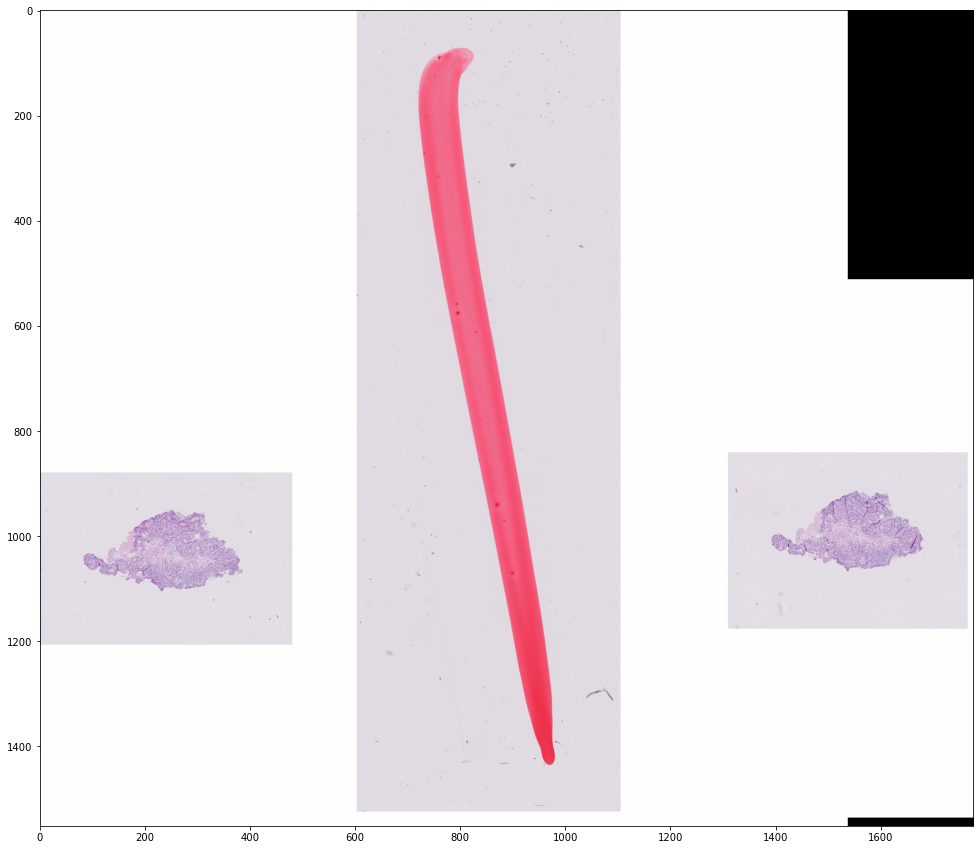

In [137]:
# wsi_path = '/data/archief/AMC-data/Barrett/Bolero_IND/RB0040_HE.tiff'
# wsa_path = '/data/archief/AMC-data/Barrett/Bolero_IND/RB0040_HE.xml'

example = -2
internal_test_examples = ['ASL/ASL08_1_HE', 'ASL/ASL26_1_HE', 'ASL35_1_HE',
                          'LANS/RL086_01_02_01_HE', 'LANS/RL059_01_03_01_HE', 'LANS/RL185_01_01_01_HE', 'LANS/RL062_01_01_01_HE', 'LANS/RL007_01_02_01_HE', 'LANS/RL044_01_02_01_HE',
                          'RBE/ROCT38_XII-HE1', 'RBE/ROCT38_XI-HE1', 'RBE/ROCT31_III-HE1', 'RBE/RBE-00115_HE']

example_path = internal_test_examples[example]
wsi_path = os.path.join('/data/archief/AMC-data/Barrett/', example_path) + '.tiff'
wsa_path = os.path.join('/data/archief/AMC-data/Barrett/', example_path) + '.xml'
print('Example: {}'.format(wsi_path))

wsa = WholeSlideAnnotation(wsa_path, labels=['biopsy-outlines'])

# open a WSI
with WholeSlideImage(wsi_path, backend='openslide') as wsi:   
    # extract the whole slide
    slide_spacing=8.0
    slide = wsi.get_slide(spacing=slide_spacing)
    
    plt.figure(figsize=(25, 15))
    plt.imshow(slide)
    plt.show()

### **(2) Extract a biopsy of interest**

In [123]:
print("Found {} biopsy outline(s).".format(len(wsa.annotations)))

# get the biopsy
biopsy = 0
bottom_left, top_right = wsa.annotations[biopsy].coordinates[0], wsa.annotations[biopsy].coordinates[2]

# get the centre of the biopsy
centre = bottom_left + ((top_right - bottom_left) / 2)
x = int(centre[0])
y = int(centre[1])
diff = top_right - bottom_left
width = int(diff[0] / 4 + tile_size)
height = int(diff[1] / 4 + tile_size)
print('x, y: {}, {}'.format(x, y))
print('width, height: {}, {}'.format(width, height))

Found 1 biopsy outline(s).
x, y: 7467, 33043
width, height: 3158, 1922


Shape of patch: (1922, 3158, 3)


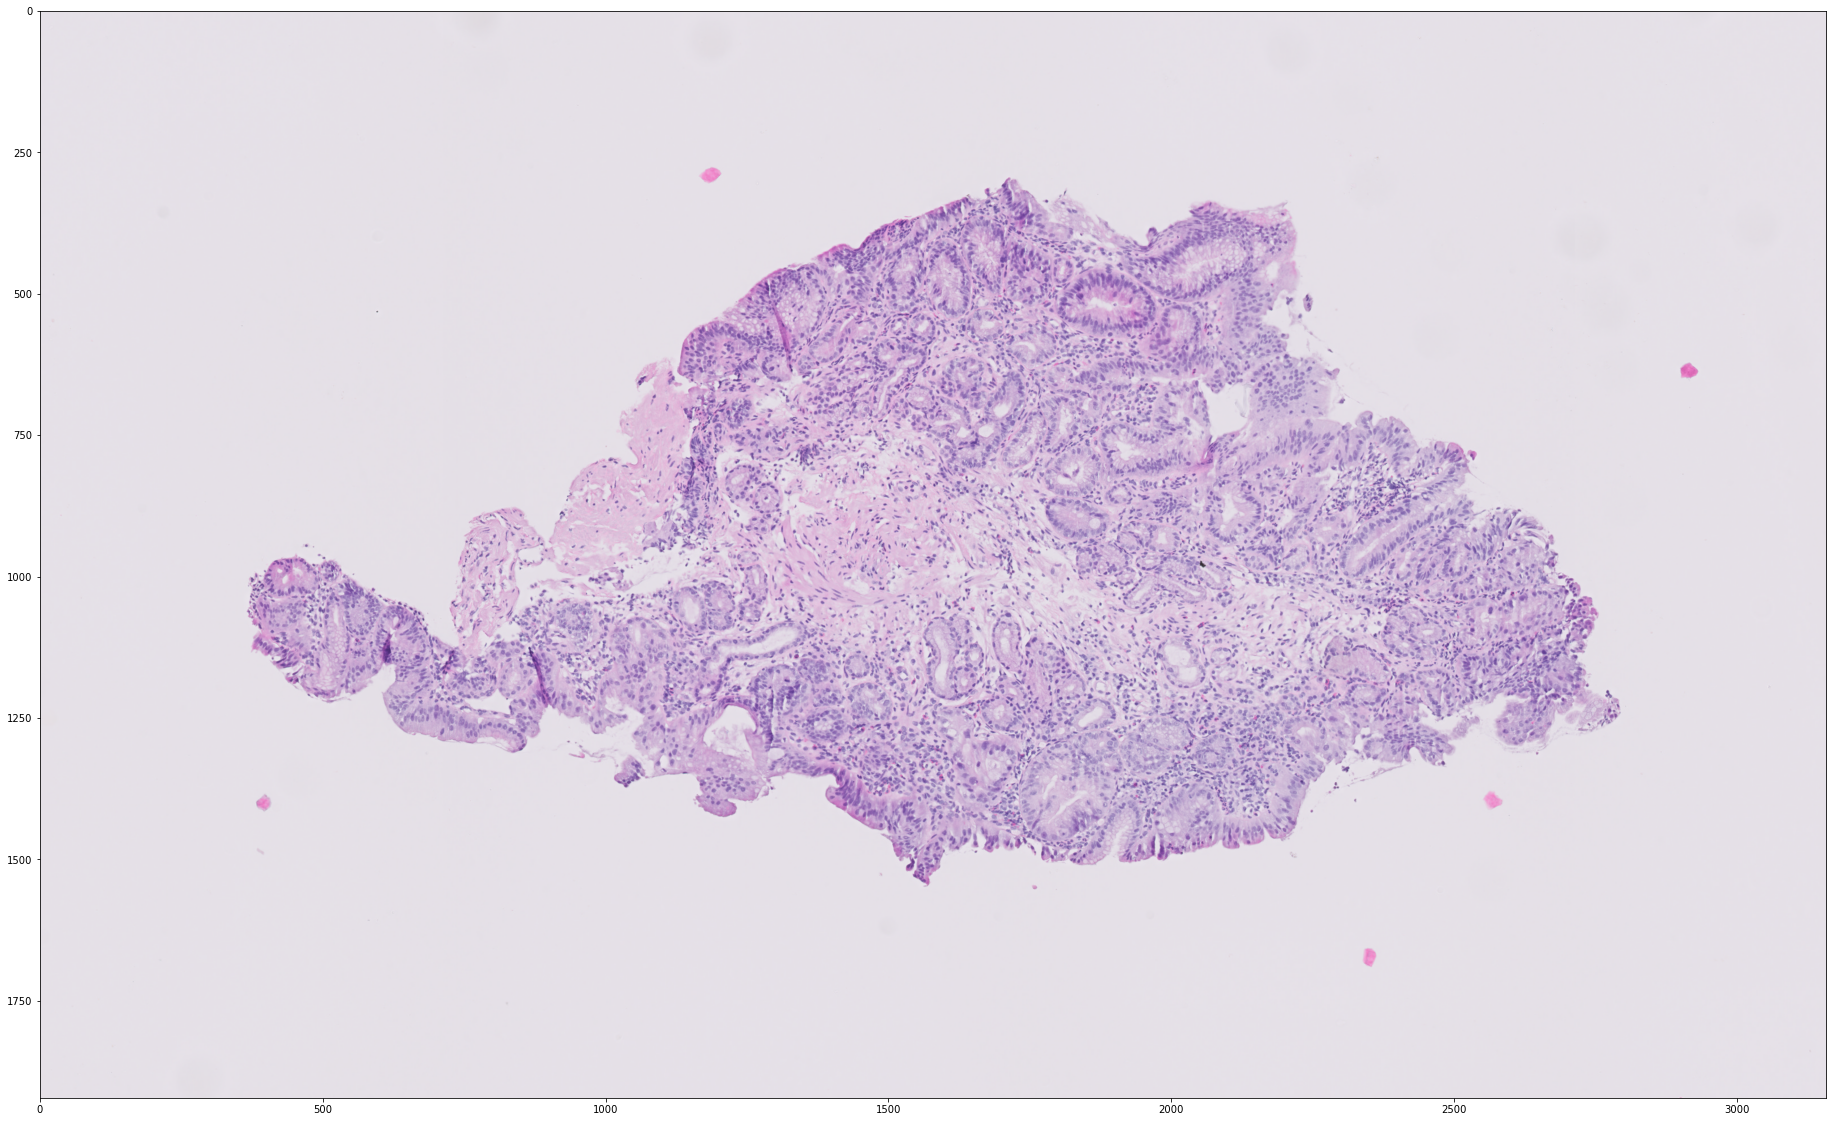

In [124]:
with WholeSlideImage(wsi_path, backend='openslide') as wsi:
    patch = wsi.get_patch(x, y, width, height, spacing=1)
    
print('Shape of patch: {}'.format(patch.shape))
plt.figure(figsize=(35, 20))
plt.imshow(patch)
# plt.title('ASL26_1_HE biopsy 4, diagnosis: LGD', fontsize=35)
plt.show()

### **(3) Run the segmentation ensemble & stitch it back together**

In [125]:
# smaller stepsize to get less stitching artifacts
tile_gen = TileGenerator(image=patch, step_size=step_size // 4, tile_size=tile_size)
segmentation = extract_segmentation(model=ensemble_m5_CE_IN, generator=tile_gen, preprocessing=preprocessing, device=device)

0it [00:00, ?it/s]

In [126]:
# define cmap
cmap = plt.cm.jet
my_cmap = cmap(np.arange(cmap.N))                # get the colormap colours
my_cmap[:, -1] = np.linspace(0.2, 0.7, cmap.N)   # set alpha as a linear gradient
my_cmap = ListedColormap(my_cmap)                # create new colourmap

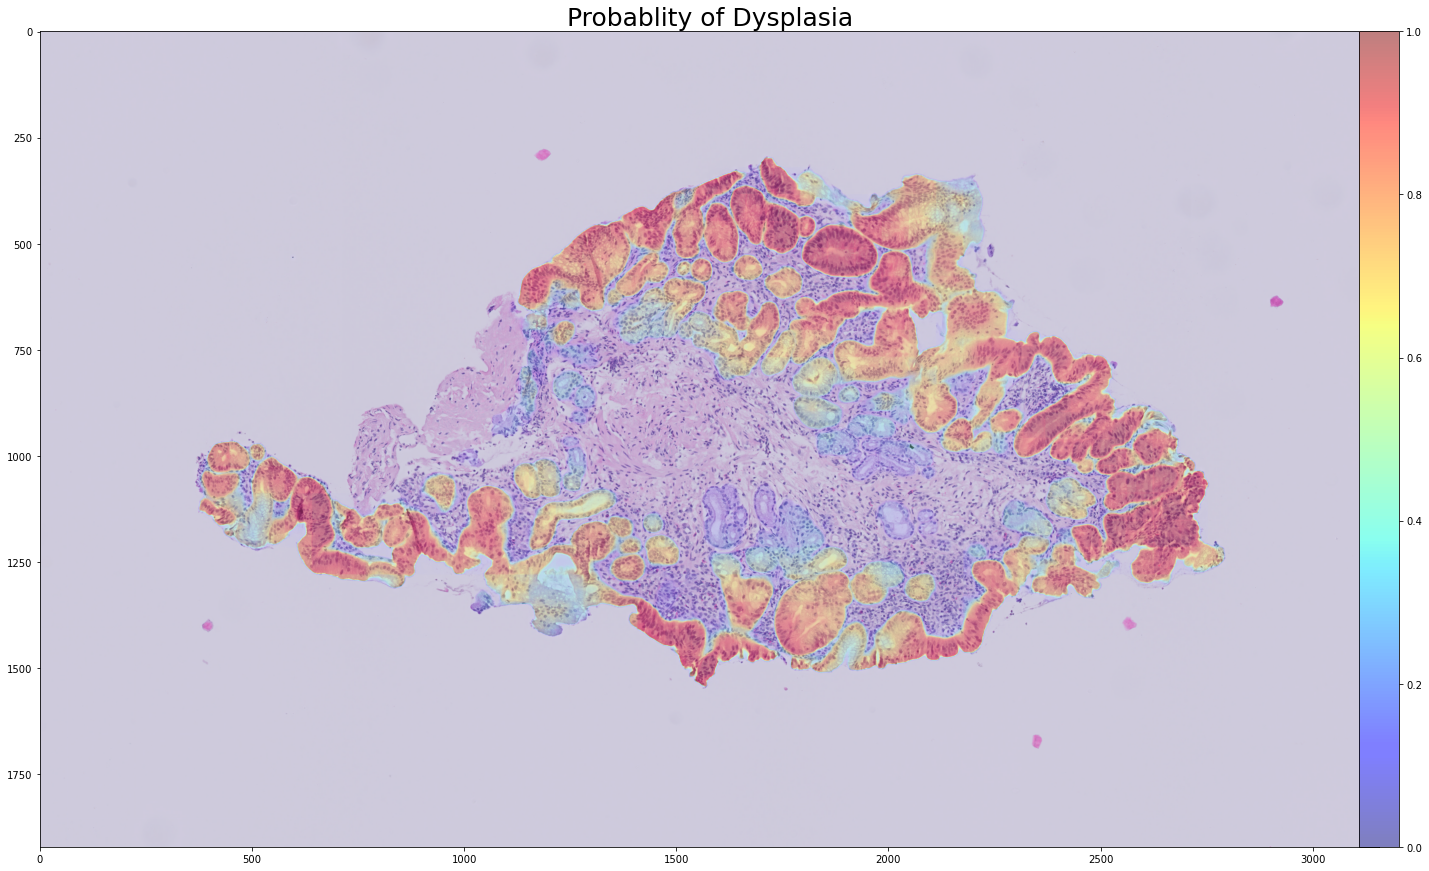

In [140]:
# dysplasia prob
y_hat_dys = segmentation[:, :, 2] + segmentation[:, :, 3]
y_hat_hard = np.argmax(segmentation, axis=2)
# y_hat_dys = gaussian(y_hat_dys, sigma=5)
# y_hat_dys = np.ma.masked_where(y_hat_hard == 0, y_hat_dys)
plt.figure(figsize=(25, 15))
plt.imshow(patch)
plt.imshow(y_hat_dys, cmap=my_cmap, alpha=0.5, vmin=0, vmax=1)
plt.colorbar(fraction=0.03, pad=-.015)
plt.title('Probablity of Dysplasia', fontsize=25)
plt.show()

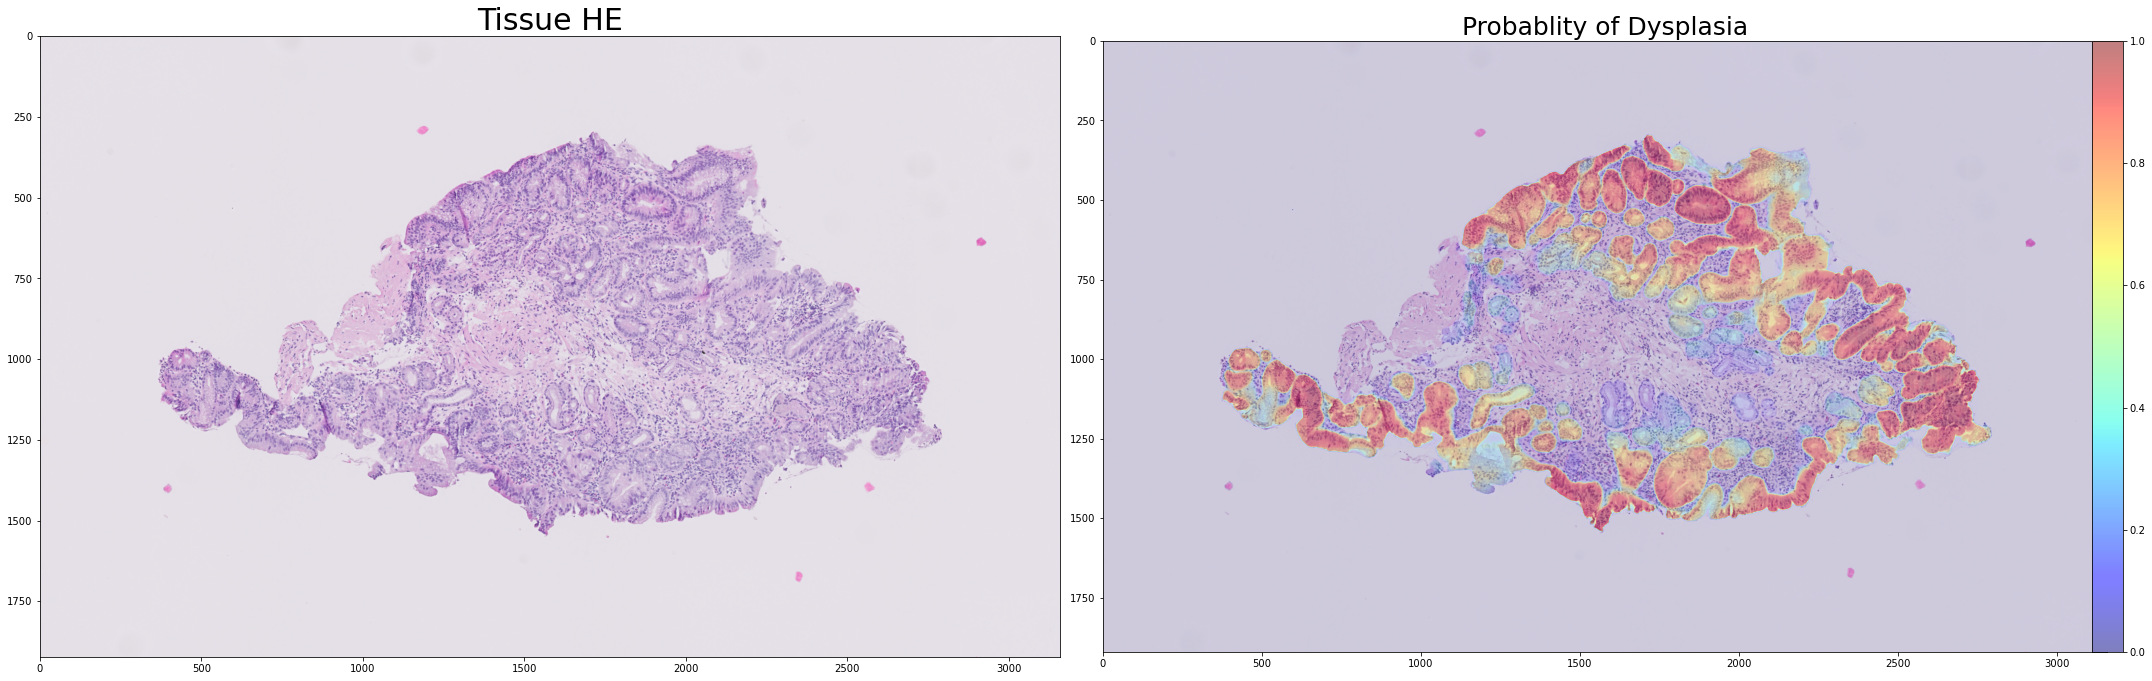

In [141]:
plt.figure(figsize=(30, 15))
plt.subplot(121)
plt.title('Tissue HE', fontsize=30)
plt.imshow(patch)
plt.subplot(122)
plt.imshow(patch)
plt.imshow(y_hat_dys, cmap=my_cmap, alpha=0.5, vmin=0, vmax=1)
plt.title('Probablity of Dysplasia', fontsize=25)
plt.colorbar(fraction=0.03, pad=-.015)
plt.tight_layout()
plt.show()

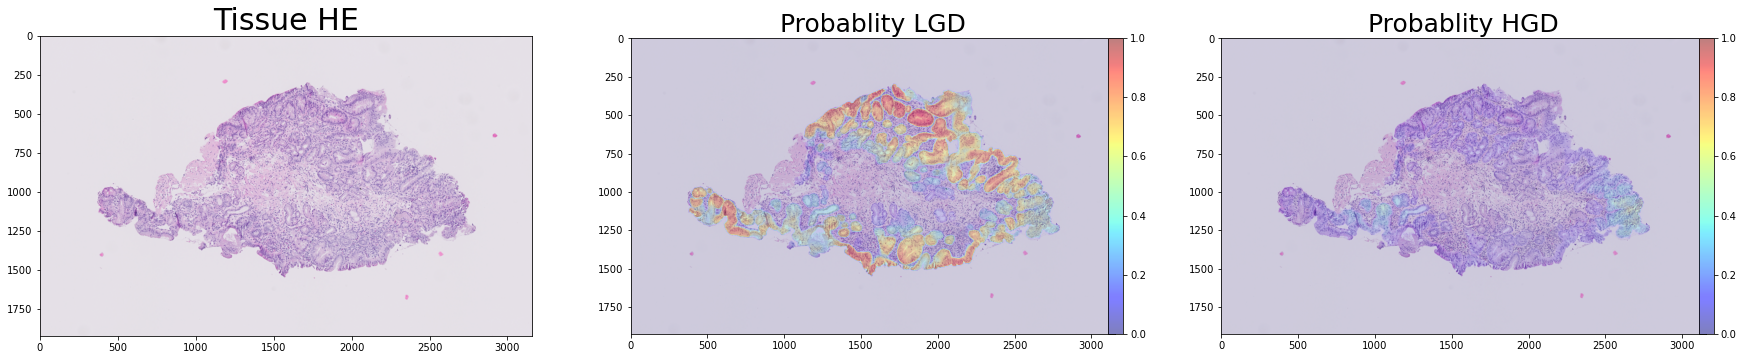

In [142]:
plt.figure(figsize=(30, 15))
plt.subplot(131)
plt.title('Tissue HE', fontsize=30)
plt.imshow(patch)
plt.subplot(132)
plt.imshow(patch)
plt.imshow(segmentation[:, :, 2], cmap=my_cmap, alpha=0.5, vmin=0, vmax=1)
plt.title('Probablity LGD', fontsize=25)
plt.colorbar(fraction=0.03, pad=-.015)
plt.subplot(133)
plt.imshow(patch)
plt.imshow(segmentation[:, :, 3], cmap=my_cmap, alpha=0.5, vmin=0, vmax=1)
plt.title('Probablity HGD', fontsize=25)
plt.colorbar(fraction=0.03, pad=-.015)
plt.show()

### **(4) Extract features for biopsy level prediction**

In [130]:
tile_gn = tile_generator(imgs=[patch], step_size=step_size, tile_size=tile_size)
info_tiles = extract_tiles(model=ensemble_m5_CE_IN, generator=tile_gn, preprocessing=preprocessing, device=device)

0it [00:00, ?it/s]

In [131]:
# rank on entropy
sus_tiles =  info_tiles[info_tiles['naive pred'] > 1].sort_values(by=['entropy pred'])[:25]

if len(sus_tiles) == 0:
    print('Did not find any dysplasia.')
    sus_tiles = info_tiles[info_tiles['naive pred'] > 0].sort_values(by=['entropy pred'])[:25]
display(sus_tiles)

loc  naive pred  \
30     (0, 1280)           2   
10   (1024, 256)           2   
36     (0, 1536)           2   
9     (768, 256)           2   
43   (256, 1792)           2   
16   (1024, 512)           2   
50   (512, 2048)           2   
56   (512, 2304)           2   
37   (256, 1536)           2   
25   (256, 1024)           2   
31   (256, 1280)           2   
34  (1024, 1280)           2   
35  (1280, 1280)           2   
52  (1024, 2048)           2   
49   (256, 2048)           2   
46  (1024, 1792)           2   
44   (512, 1792)           2   
41  (1280, 1536)           2   
51   (768, 2048)           2   
47  (1280, 1792)           2   
53  (1280, 2048)           2   
42     (0, 1792)           2   
40  (1024, 1536)           2   
28  (1024, 1024)           2   
38   (512, 1536)           2   

                                              avg msp  avg msp pred  \
30  [0.77215034, 0.016908653, 0.18787299, 0.023067...      0.187873   
10  [0.7758372, 0.024082445, 0.18111023, 0.018970007]      0.181110   
36  [0.7482896, 0.027884925, 0.19941033, 0.024415163]      0.199410   
9   [0.75512564, 0.028091658, 0.19476186, 0.02202088]      0.194762   
43   [0.46491277, 0.07586945, 0.4167946, 0.042423133]      0.416795   
16  [0.7111811, 0.034333464, 0.22490521, 0.029580263]      0.224905   
50    [0.4926628, 0.045877285, 0.4017015, 0.05975843]      0.401702   
56  [0.7562278, 0.012379115, 0.18812607, 0.043267045]      0.188126   
37   [0.40464818, 0.06937525, 0.45391488, 0.07206176]      0.453915   
25  [0.67652917, 0.057897396, 0.23436132, 0.03121216]      0.234361   
31  [0.45840693, 0.09934851, 0.39048603, 0.051758513]      0.390486   
34     [0.5604603, 0.1439091, 0.26250824, 0.03312232]      0.262508   
35    [0.7873398, 0.017471887, 0.1593957, 0.03579248]      0.159396   
52    [0.678513, 0.07192281, 0.21757145, 0.031992797]      0.217571   
49   [0.732242, 0.043080535, 0.20189793, 0.022779485]      0.201898   
46    [0.6120819, 0.13424008, 0.2322994, 0.021378629]      0.232299   
44  [0.32531667, 0.15721725, 0.46132216, 0.056143943]      0.461322   
41   [0.68831784, 0.03749786, 0.2277935, 0.046390776]      0.227793   
51   [0.45689794, 0.10941354, 0.37140048, 0.06228802]      0.371400   
47  [0.7404467, 0.050425444, 0.18028295, 0.028844956]      0.180283   
53  [0.883619, 0.017770926, 0.085810184, 0.012799895]      0.085810   
42   [0.788256, 0.13735309, 0.06917362, 0.0052172933]      0.069174   
40  [0.47178894, 0.22990103, 0.27050024, 0.027809836]      0.270500   
28     [0.5884069, 0.0835509, 0.27846393, 0.04957823]      0.278464   
38  [0.44497404, 0.15070729, 0.34252232, 0.061796416]      0.342522   

                                             max msp  max msp pred  \
30   [0.99975693, 0.25282294, 0.9119465, 0.22236654]      0.911946   
10    [0.9997546, 0.47740668, 0.9298236, 0.21963513]      0.929824   
36  [0.99972117, 0.45037675, 0.92610276, 0.21159784]      0.926103   
9    [0.99981403, 0.51329327, 0.9228193, 0.18739377]      0.922819   
43  [0.99976444, 0.82778466, 0.94513625, 0.17875664]      0.945136   
16   [0.99974614, 0.56026495, 0.9236506, 0.17939198]      0.923651   
50     [0.9996092, 0.7125761, 0.9101653, 0.23271053]      0.910165   
56   [0.99970067, 0.1961705, 0.88347405, 0.27041447]      0.883474   
37   [0.99972296, 0.64586526, 0.9283242, 0.22730628]      0.928324   
25   [0.9997438, 0.60070765, 0.92097664, 0.17297676]      0.920977   
31     [0.99975264, 0.65115774, 0.8909418, 0.204583]      0.890942   
34     [0.9996708, 0.9237769, 0.9127922, 0.22149411]      0.912792   
35    [0.999705, 0.27718985, 0.89568645, 0.25735918]      0.895686   
52   [0.99974716, 0.8988568, 0.90155727, 0.21140835]      0.901557   
49    [0.9996975, 0.44043487, 0.8703081, 0.18447194]      0.870308   
46    [0.99976176, 0.89350015, 0.9138382, 0.1909008]      0.913838   
44    [0.9997619, 0.83469886, 0.8891886, 0.18935129]      0.889189   
41    [0.9997319, 0.45788163, 0.87935543, 0.2842087]      0.879355   
51 

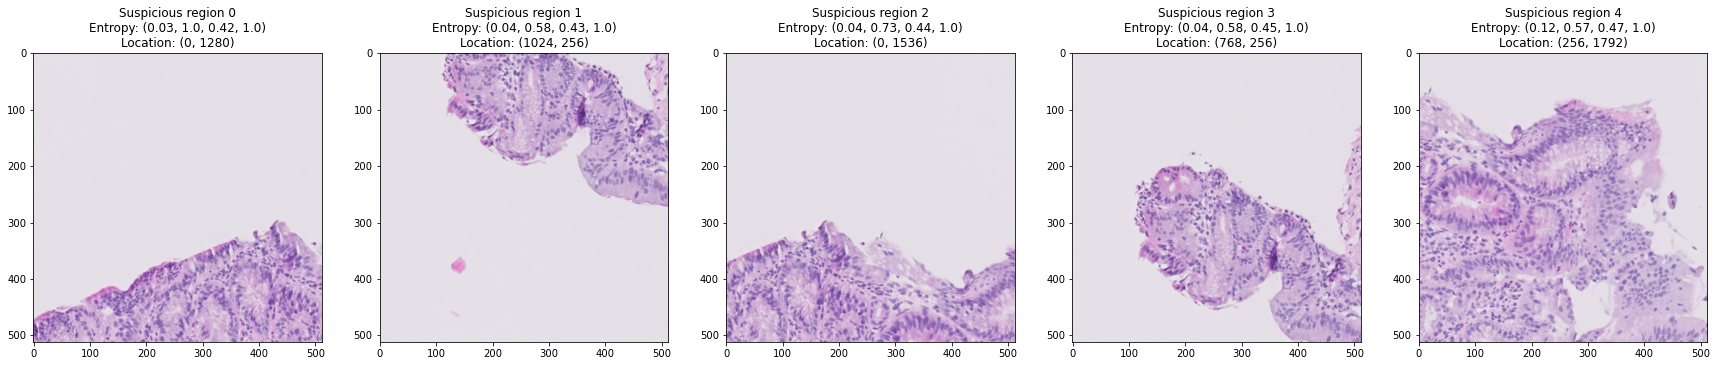

In [132]:
# plot 5 most sus regions
sus_tiles_top_5 = sus_tiles[:5]
fig, ax = plt.subplots(1, len(sus_tiles_top_5), figsize=(30, 15))

for idx, sus_tile in enumerate(sus_tiles_top_5.iterrows()):
    x_coord, y_coord = sus_tile[1]['loc']
    sus_region = patch[x_coord: x_coord + tile_size, y_coord: y_coord + tile_size]
    ax[idx].imshow(sus_region)
    ax[idx].title.set_text('Suspicious region {}\nEntropy: {}\nLocation: {}'.format(idx, tuple(np.round(sus_tile[1]['entropy sk'], decimals=2)), (x_coord, y_coord))) 

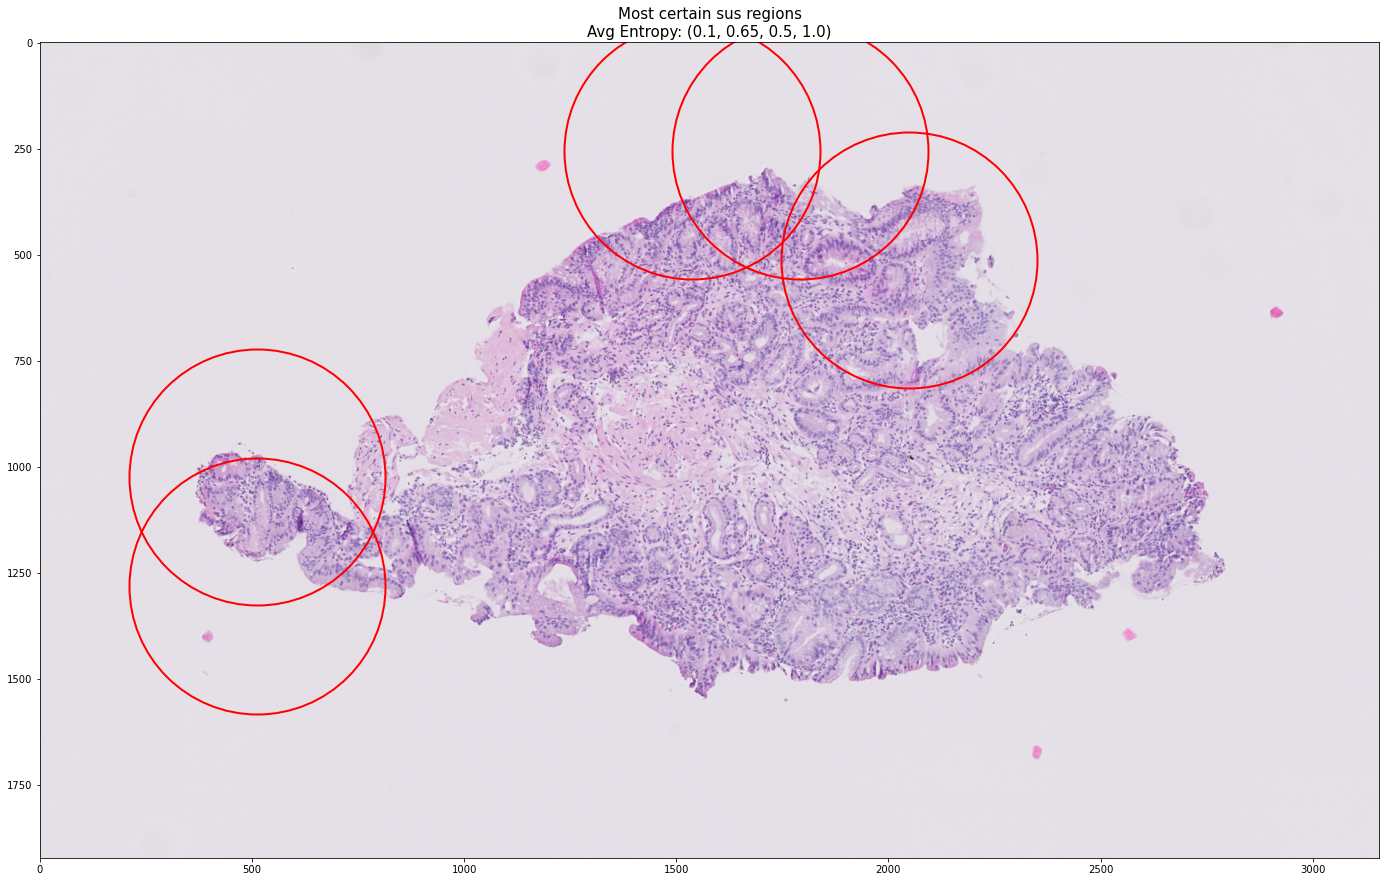

In [133]:
fig, ax = plt.subplots(figsize=(25, 15))
ax.imshow(patch)


for idx, sus_reg in sus_tiles_top_5.iterrows():
    x_coord, y_coord = sus_reg['loc']
    xy = (y_coord + 0.5 * tile_size, x_coord + 0.5 * tile_size)

    # draw a circle around the centre of the sus region
    circle_rad = 0.5 * tile_size
    ax.plot(xy[0], xy[1], 'o', ms=circle_rad, mec='r', mfc='none', mew=2)
    
#     # draw a rectangle
#     xy = (y_coord, x_coord)
#     rectangle = Rectangle(xy, tile_size, tile_size, edgecolor='r', linewidth=2, facecolor='none')
#     ax.add_patch(rectangle)
    
plt.title('Most certain sus regions\nAvg Entropy: {}'.format(tuple(np.round(np.mean(sus_tiles['entropy sk']), decimals=2))), fontsize=15)
plt.show()

### **Biopsy level Prediction**
**Note: it was trained at WSI prediction level, i.e.: the top 25 most certain dysplasia regions in a complete WSI (from the biopsy outlines) were used.**

In [134]:
# prepare input sequence
x = np.zeros((1, 25, 4))

for tile_idx, tile in sus_tiles.reset_index().iterrows():      
    x[0, tile_idx, 0:4] = tile['entropy sk']    

# make the prediction
classes = ['NDBE', 'LGD', 'HGD'] 
y_logits = model_st.forward(torch.Tensor(x))
y_prob = torch.softmax(y_logits, dim=0).detach().cpu().numpy()
y_pred = np.argmax(y_prob, axis=0)
print('Diagnosis {} with probs NDBE: {:.2f}, LGD: {:.2f}, HGD: {:.2f}'.format(classes[y_pred], y_prob[0], y_prob[1], y_prob[2]))

Diagnosis LGD with probs NDBE: 0.26, LGD: 0.55, HGD: 0.19


### **(5) Whole Slide Level Prediction**
Using tissue from all the biopsie outlines in this example.

In [135]:
biopsies = []

# get the biopsies
for annotation in wsa.annotations:

    bottom_left, top_right = annotation.coordinates[0], annotation.coordinates[2]

    # get the centre of the biopsy
    centre = bottom_left + ((top_right - bottom_left) / 2)
    x = int(centre[0])
    y = int(centre[1])
    diff = top_right - bottom_left
    width = int(diff[0] / 4 + tile_size)
    height = int(diff[1] / 4 + tile_size)
    
    with WholeSlideImage(wsi_path, backend='openslide') as wsi:
        biopsy = wsi.get_patch(x, y, width, height, spacing=1)
        
    biopsies.append(biopsy)
    
# tile gen WSI level
tile_gn = tile_generator(imgs=biopsies, step_size=step_size, tile_size=tile_size)
info_tiles = extract_tiles(model=ensemble_m5_CE_IN, generator=tile_gn, preprocessing=preprocessing, device=device)

0it [00:00, ?it/s]

In [136]:
# rank on entropy
sus_tiles =  info_tiles[info_tiles['naive pred'] > 1].sort_values(by=['entropy pred'])[:25]

if len(sus_tiles) == 0:
    print('Did not find any evidence of dysplasia.')
    sus_tiles = info_tiles[info_tiles['naive pred'] > 0].sort_values(by=['entropy pred'])[:25]

# prepare input sequence
x = np.zeros((1, 25, 4))

for tile_idx, tile in sus_tiles.reset_index().iterrows():      
    x[0, tile_idx, 0:4] = tile['entropy sk']    

# make the prediction
classes = ['NDBE', 'LGD', 'HGD'] 
y_logits = model_st.forward(torch.Tensor(x))
y_prob = torch.softmax(y_logits, dim=0).detach().cpu().numpy()
y_pred = np.argmax(y_prob, axis=0)
print('Diagnosis {} with probs NDBE: {:.2f}, LGD: {:.2f}, HGD: {:.2f}'.format(classes[y_pred], y_prob[0], y_prob[1], y_prob[2]))

# Class pairwise entropies on pixel level
avg_pixelwise_entropy = tuple(np.round(np.mean(sus_tiles['entropy sk']), decimals=2))
print('Entropy avg pixel level: {}'.format(avg_pixelwise_entropy))

# Slide level class pairwise entropy:
slide_entropy = tuple(np.round(entropy_slide(y_prob), decimals=2))
print('Entropy slide level: {}'.format(slide_entropy))

Diagnosis LGD with probs NDBE: 0.26, LGD: 0.55, HGD: 0.19
Entropy avg pixel level: (0.1, 0.65, 0.5, 1.0)
Entropy slide level: (0.28, 0.33, 0.23)
